In [39]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

In [40]:
test_dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Detection/Test set"
images_dir = f"{test_dataset_path}/images"
labels_dir = f"{test_dataset_path}/labels/obj_train_data"

In [ ]:
def yolo_to_pixel(coord, img_W, img_H):
    """
    Compute the coordinates of the bbox in pixels term.

    Args:
        coord (tuple): Bbox in YOLO format.
        img_W (int): Width of the image.
        img_H (int): Height of the image.

    Returns:
        tuple: The coordinate of the top left an the bottom right corner of the bbox in pixel term.
    """ 
    x, y, w, h = coord
    
    x1 = max(0, int((x - w / 2) * img_W)) 
    y1 = max(0, int((y - h / 2) * img_H))
    x2 = min(img_W, int((x + w / 2) * img_W))
    y2 = min(img_H, int((y + h / 2) * img_H))

    return x1, y1, x2, y2

def face_to_yolo_relative_to_body(body_bbox, face_bbox):
    """
    Compute the coordinates of the bbox of the face relative to the bbox of the body.

    Args:
        body_bbox (tuple): Bbox of the body in YOLO format.
        face_bbox (tuple): Bbox of the face in YOLO format.

    Returns:
        tuple: The coordinate of the face relatively to the body in YOLO format.
    """ 
    bx1, by1, bx2, by2 = body_bbox 
    fx1, fy1, fx2, fy2 = face_bbox  
    
    if fx1 < bx1: 
        fx1 = bx1
    if fy1 < by1: 
        fy1 = by1
    if fx2 > bx2: 
        fx2 = bx2
    if fy2 > by2: 
        fy2 = by2

    # Taille du bounding box du corps
    body_width = bx2 - bx1
    body_height = by2 - by1

    # Coords du visage dans le référentiel du corps
    rel_x1 = fx1 - bx1
    rel_y1 = fy1 - by1
    rel_x2 = fx2 - bx1
    rel_y2 = fy2 - by1

    # Calcul YOLO par rapport au corps
    x_center = (rel_x1 + rel_x2) / 2 / body_width
    y_center = (rel_y1 + rel_y2) / 2 / body_height
    width = (rel_x2 - rel_x1) / body_width
    height = (rel_y2 - rel_y1) / body_height

    return x_center, y_center, width, height

def get_corresponding_body(face, bodies,  width, height):
    """
    Find the bbox of the body that is link to the face in pixels term.

    Args:
        face (tuple): Bbox of the face in pixel term.
        bodies (list): List of the bboxes of the bodies in YOLO format.
        width (int): Width of the image.
        height (int): Height of the image.

    Returns:
        tuple: The coordinate of the top left and bootom right corner of the bbox of the body related to the asked face.
    """ 
    fx1, fy1, fx2, fy2 = face  # Décomposer les coordonnées du visage
    best_body = None
    best_overlap = 0  # On cherche le corps avec la plus grande inclusion du visage

    for body in bodies:
        bx1, by1, bx2, by2 = yolo_to_pixel(body, width, height)  # Décomposer les coordonnées du corps

        # Vérifier si le visage est entièrement contenu dans le corps
        if bx1 <= fx1 and bx2 >= fx2 and by1 <= fy1 and by2 >= fy2:
            # Calcul de l'aire du visage et du corps
            face_area = (fx2 - fx1) * (fy2 - fy1)
            body_area = (bx2 - bx1) * (by2 - by1)

            # On cherche le corps qui minimise le rapport face/corps (plus petite zone englobante)
            overlap = face_area / body_area
            if overlap > best_overlap:
                best_overlap = overlap
                best_body = body  # On garde le corps optimal

    if best_body == None: 
        return None
    return yolo_to_pixel(best_body, width, height)  # Retourne le corps correspondant ou None si aucun trouvé


In [ ]:
counter = 0
for root, _, files in os.walk(labels_dir):  # On ignore la liste des sous-dossiers avec "_"
    for file in files:
        faces = []
        bodies = []
        #Séparer les bboxes en fonction de si face ou body
        with open(f"{labels_dir}/{file}", "r") as current_file:
            for line in current_file:
                values = tuple(float(value) for value in line.strip().split(" "))
                if values[0] == 0: 
                    faces.append(values[1:])
                else: 
                    bodies.append(values[1:])

        #Ouvrir l'image correspondant aux annotations qu'on vient de récupérer
        img = Image.open(images_dir + f"/{file[:-4]}.png")
        frame = np.array(img)
        height, width, _ = frame.shape

        face_coord = None 
        body_coord = None
        for face in faces: 
            #Trouver le body correspondant à la face actuellement traîtée
            face_coord = tuple(yolo_to_pixel(face, width, height))
            body_coord = get_corresponding_body(face_coord, bodies, width, height)

            if body_coord is None: 
                continue

            fx1, fy1, fx2, fy2 = face_coord
            bx1, by1, bx2, by2 = body_coord

            #Crop l'image autour du body et la save + faire un csv qui donne les coord de la face par rapport à l'image crop autour du body
            cropped_body = frame[by1:by2, bx1:bx2]
            image_pil = Image.fromarray(np.uint8(cropped_body))
            image_pil.save(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_test_dataset/images/body{counter}.png")

            face_yolo_coord = face_to_yolo_relative_to_body((bx1, by1, bx2, by2), (fx1, fy1, fx2, fy2))

            with open(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_test_dataset/labels/body{counter}.txt", "w") as file:
                file.write("0 " + " ".join(map(str, face_yolo_coord))) 
            counter+= 1


<h3>Test<h3>

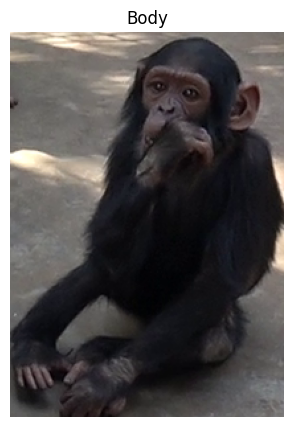

(0.0, 0.6642512077294686, 0.1718213058419244, 0.4975845410628019, 0.3230240549828179)


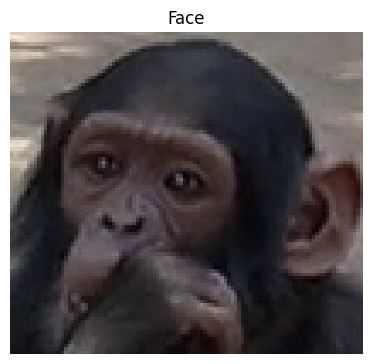

In [46]:
img = Image.open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_test_dataset/images/body56.png")
frame = np.array(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("Body")
plt.axis("off")
plt.show()

with open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_test_dataset/labels/body56.txt", "r") as file:
    content = file.readline().strip()
    values = content.split(" ")

values = tuple([float(v) for v in values])

print(values)

height, width, _ = frame.shape

x1,y1,x2,y2 = yolo_to_pixel(values[1:], width, height)
test_image = frame[y1:y2, x1:x2]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Face")
plt.axis("off")
plt.show()